# Facial Emotion Recogination

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

## Importing dataset

In [2]:
train_directory = '../input/fer2013/train/'
test_directory = '../input/fer2013/test/'

rows, cols = 48, 48
num_classes = 7

def count_expression(directory_path, dataset_type):
    expression_dict = {}
    for expression in os.listdir(directory_path):
        sub_directory = directory_path + expression
        expression_dict[expression] = len(os.listdir(sub_directory))
    dataframe = pd.DataFrame(expression_dict, index=[dataset_type])
    return dataframe

train_count = count_expression(train_directory, 'train')
test_count = count_expression(test_directory, 'test')

print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


### PLot of number of images in training set

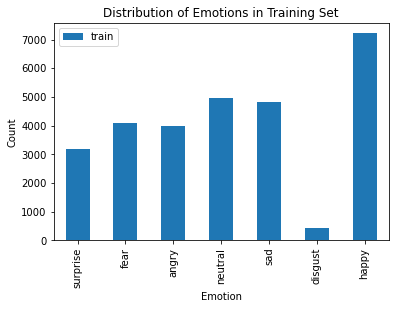

In [3]:
train_count_transposed = train_count.transpose()
train_count_transposed.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in Training Set')
plt.show()

### PLot of number of images in test set

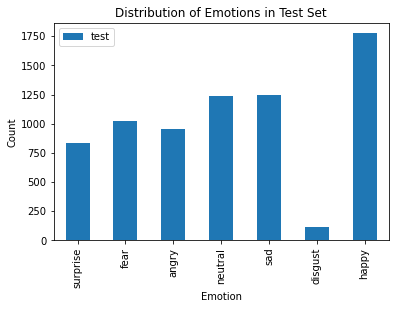

In [4]:
test_count_transposed = test_count.transpose()
test_count_transposed.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in Test Set')
plt.show()

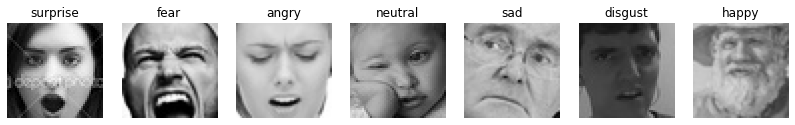

In [5]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_directory):
    # Load a sample image from each expression directory
    img_path = os.path.join(train_directory, expression, os.listdir(os.path.join(train_directory, expression))[0])
    img = load_img(img_path)
    
    # Plot the image
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1

plt.show()

## Creating training and test sets

In [6]:
# ImageDataGenerator for training set with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

# Creating a flow generator for the training set
training_set = train_datagen.flow_from_directory(train_directory,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

# ImageDataGenerator for test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating a flow generator for the test set
test_set = test_datagen.flow_from_directory(train_directory,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [7]:
# Provides a dictionary mapping class names to their respective indices
class_indices = training_set.class_indices
print(class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Defining Model

In [8]:
def get_model(input_size, num_classes=7):
    #Initialize the CNN
    model = tf.keras.models.Sequential()   
    
    # Convolutional layers
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    # Flatten the feature maps
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

     # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
# Create an instance of a convolutional neural network (CNN) model 
emotion_model = get_model((rows,cols,1), num_classes)

# Summary of the model
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

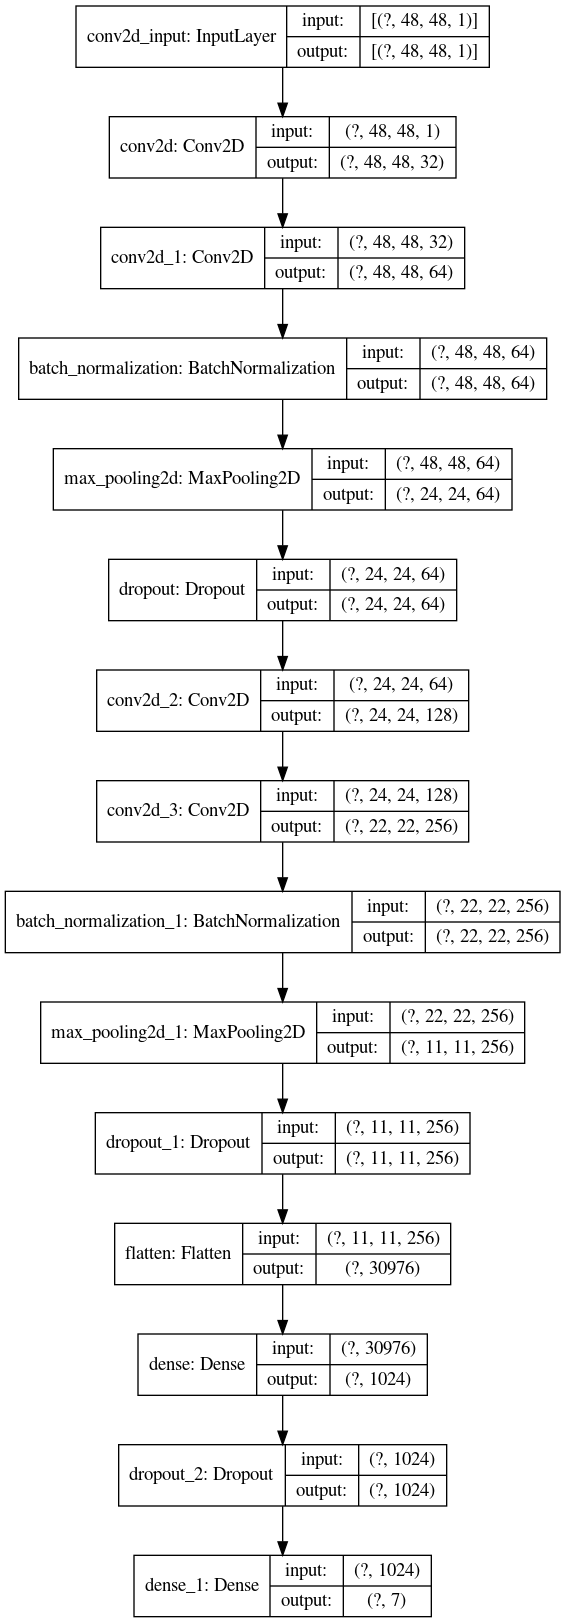

In [10]:
# Visualize the architecture of a neural network model
plot_model(emotion_model, to_file='emotion_model.png', show_shapes=True, show_layer_names=True)

### Callback function

In [11]:
# Path to save the best model checkpoint
model_checkpoint_path = 'emotion_model.h5'

# Directory for logging
log_directory = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Model model_checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=model_checkpoint_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

# Reduce learning rate callback
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory, histogram_freq=1)

# CSV logger callback
csv_logger = CSVLogger('training.log')

# List of callbacks to be used during model training
callbacks = [model_checkpoint, reduce_learning_rate , csv_logger]

## Training model

In [12]:
# Determine steps per epoch and validation steps
training_steps_per_epoch = training_set.n // training_set.batch_size
validation_steps_per_epoch  = test_set.n // test_set.batch_size

# Train the model using fit method
history = emotion_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=training_steps_per_epoch,
                 validation_steps =validation_steps_per_epoch )

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2608 - accuracy: 0.2761
Epoch 00001: val_loss improved from inf to 4.24355, saving model to emotion_model.h5
448/448 [==============================] - 151s 337ms/step - loss: 4.2608 - accuracy: 0.2761 - val_loss: 4.2436 - val_accuracy: 0.3181
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.4559 - accuracy: 0.3328
Epoch 00002: val_loss improved from 4.24355 to 3.13948, saving model to emotion_model.h5
448/448 [==============================] - 55s 122ms/step - loss: 3.4559 - accuracy: 0.3328 - val_loss: 3.1395 - val_accuracy: 0.4093
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9253 - accuracy: 0.3740
Epoch 00003: val_loss improved from 3.13948 to 2.57024, saving model to emotion_model.h5
448/448 [==============================] - 55s 124ms/step - loss: 2.9253 - accuracy: 0.3740 - val_loss: 2.5702 - val_accuracy: 0.4433
Epoch 4/60
448/448 [==========================

## Loss and accuracy plot

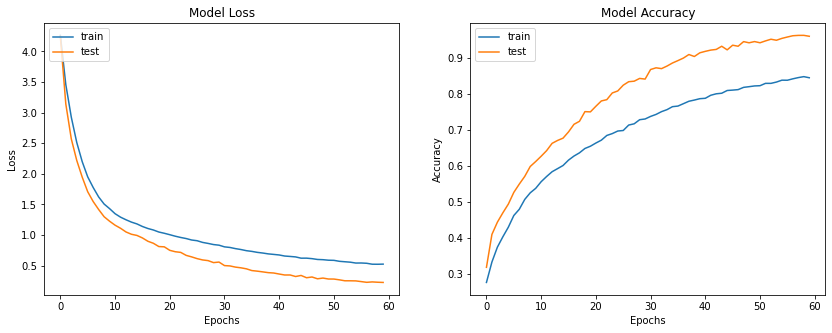

In [13]:
plt.figure(figsize=(14,5))

# Plot for Model Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

# Plot for Model Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

### Model evaluation

In [14]:
train_loss, train_accuracy = emotion_model.evaluate(training_set)

test_loss, test_accuracy = emotion_model.evaluate(test_set)

print("Final training accuracy: {:.2f}%, Validation accuracy: {:.2f}%".format(train_accuracy * 100, test_accuracy * 100))

449/449 [==============================] - 22s 50ms/step - loss: 0.2239 - accuracy: 0.9589
Final training accuracy: 93.09%, Validation accuracy: 95.89%


In [15]:
emotion_model.save_weights('emotion_model_bestweight.h5')